# 第5章 大規模言語モデルのファインチューニング

**注意**
2023/7/28現在、MARC-jaのデータセットの配布元のリンクが切れており、書籍上の5.2、5.3、5.5.4節に掲載されているコードにおいて、データセット読み込みの箇所でエラーが出る状態です。こちらのノートブックは、MARC-jaと同様の感情分析のデータセットであるWRIMEを用いて書籍と同様のコードを実行するために用意されています。

## 5.5 メモリ効率の良いファインチューニング

### 5.5.4 LoRAチューニング

#### 環境の準備

In [1]:
!pip install transformers[ja,torch] datasets matplotlib japanize-matplotlib peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 56.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 25.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.4/698.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from transformers.trainer_utils import set_seed

# 乱数シードを42に固定
set_seed(42)

#### データセットの準備

In [3]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のllm-book/wrime-sentimentのリポジトリから
# データを読み込む
train_dataset = load_dataset("llm-book/wrime-sentiment", split="train")
valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation")
# pprintで見やすく表示する
pprint(train_dataset[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

wrime-sentiment.py:   0%|          | 0.00/3.35k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/178k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/178k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20149 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1608 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1781 [00:00<?, ? examples/s]

{'datetime': '2012/7/31 23:48',
 'label': 1,
 'sentence': 'ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…',
 'user_id': 1}


In [4]:
pprint(train_dataset.features)

{'datetime': Value(dtype='string', id=None),
 'label': ClassLabel(names=['positive', 'negative'], id=None),
 'sentence': Value(dtype='string', id=None),
 'user_id': Value(dtype='int64', id=None)}


#### トークナイザ

In [5]:
from transformers import AutoTokenizer

# Hugging Face Hub上のモデル名を指定
model_name = "cl-tohoku/bert-base-japanese-v3"
# モデル名からトークナイザを読み込む
tokenizer = AutoTokenizer.from_pretrained(model_name)
# トークナイザのクラス名を確認
print(type(tokenizer).__name__)

tokenizer_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

BertJapaneseTokenizer


In [6]:
tokenizer.tokenize("これはテストです。")

['これ', 'は', 'テスト', 'です', '。']

In [7]:
encoded_input = tokenizer("これはテストです。")
# 出力されたオブジェクトのクラスを表示
print(type(encoded_input).__name__)

BatchEncoding


In [8]:
pprint(encoded_input)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'input_ids': [2, 12538, 465, 14985, 13037, 385, 3],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0]}


In [9]:
tokenizer.convert_ids_to_tokens(encoded_input["input_ids"])

['[CLS]', 'これ', 'は', 'テスト', 'です', '。', '[SEP]']

#### データセット統計の可視化

100%|██████████| 20149/20149 [00:05<00:00, 3996.35it/s]


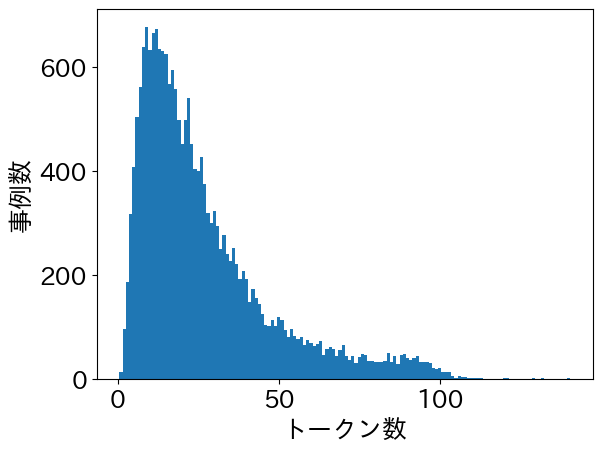

100%|██████████| 1608/1608 [00:00<00:00, 4014.80it/s]


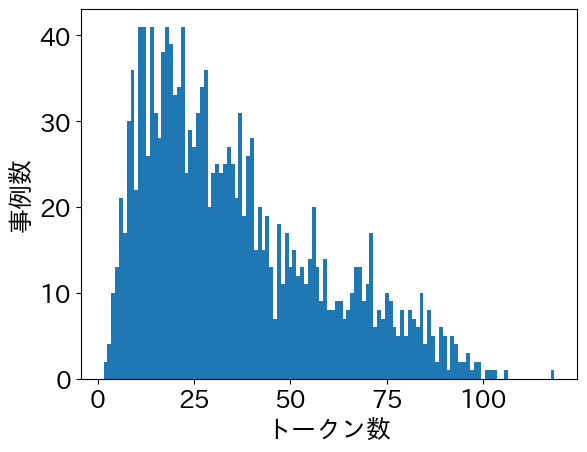

In [10]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

def visualize_text_length(dataset: Dataset):
    """データセット中のテキストのトークン数の分布をグラフとして描画"""
    # データセット中のテキストの長さを数える
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["sentence"]))
        length_counter[length] += 1
    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()

visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)

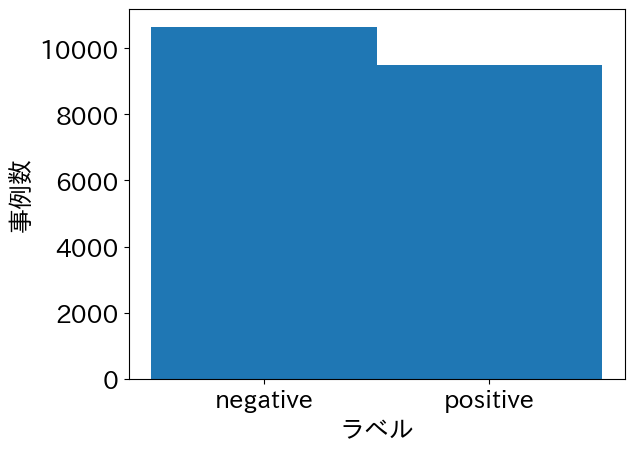

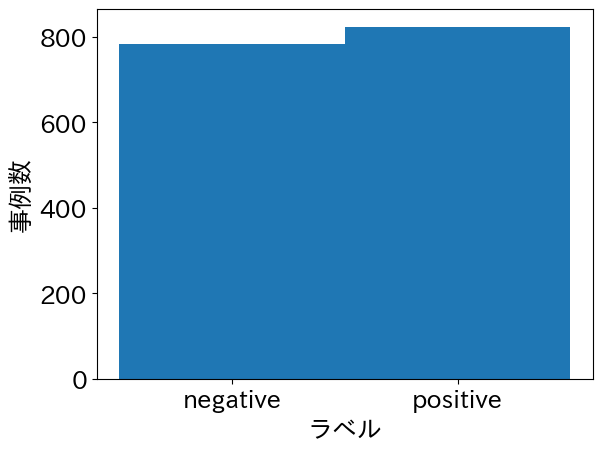

In [11]:
def visualize_labels(dataset: Dataset):
    """データセット中のラベル分布をグラフとして描画"""
    # データセット中のラベルの数を数える
    label_counter = Counter()
    for data in dataset:
        label_id = data["label"]
        label_name = dataset.features["label"].names[label_id]
        label_counter[label_name] += 1
    # label_counterを棒グラフとして描画する
    plt.bar(label_counter.keys(), label_counter.values(), width=1.0)
    plt.xlabel("ラベル")
    plt.ylabel("事例数")
    plt.show()

visualize_labels(train_dataset)
visualize_labels(valid_dataset)

#### データセットの前処理

In [12]:
from transformers import BatchEncoding

def preprocess_text_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """文書分類の事例のテキストをトークナイズし、IDに変換"""
    encoded_example = tokenizer(example["sentence"], max_length=512)
    # モデルの入力引数である"labels"をキーとして格納する
    encoded_example["labels"] = example["label"]
    return encoded_example

In [13]:
encoded_train_dataset = train_dataset.map(
    preprocess_text_classification,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text_classification,
    remove_columns=valid_dataset.column_names,
)

Parameter 'function'=<function preprocess_text_classification at 0x7c8c3d2eff60> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/20149 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/1608 [00:00<?, ? examples/s]

In [14]:
print(encoded_train_dataset[0])

{'input_ids': [2, 478, 7139, 15269, 441, 456, 13123, 21311, 12671, 385, 12651, 7065, 12485, 12488, 13781, 461, 457, 13030, 464, 461, 29, 29, 29, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 1}


#### ミニバッチ構築

In [15]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [16]:
batch_inputs = data_collator(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 36]),
 'input_ids': torch.Size([4, 36]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 36])}


#### モデルの準備

In [17]:
from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes,
    label2id=label2id,  # ラベル名からIDへの対応を指定
    id2label=id2label,  # IDからラベル名への対応を指定
)
print(type(base_model).__name__)

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification


In [18]:
import peft

peft_config = peft.LoraConfig(
    task_type=peft.TaskType.SEQ_CLS,  # モデルが解くタスクのタイプを指定
    r=8,  # 差分行列のランク
    lora_alpha=32,  #  LoRA層の出力のスケールを調節するハイパーパラメータ
    lora_dropout=0.1,  # LoRA層に適用するドロップアウト
    inference_mode=False,  # 推論モードの設定（今回は学習時なのでFalse）
)
model = peft.get_peft_model(base_model, peft_config)
print(type(model).__name__)

PeftModelForSequenceClassification


In [19]:
model.print_trainable_parameters()

trainable params: 296,450 || all params: 111,505,156 || trainable%: 0.2659


In [20]:
print(model.forward(**data_collator(encoded_train_dataset[0:4])))

SequenceClassifierOutput(loss=tensor(0.8075, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.2869, -0.2644],
        [ 0.1715,  0.0095],
        [ 0.0040,  0.1524],
        [ 0.2233, -0.2968]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


#### 訓練の実行

In [21]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_wrime_lora",  # 結果の保存フォルダ
    per_device_train_batch_size=32,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    learning_rate=2e-4,  # 学習率
    lr_scheduler_type="linear",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=3,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
    fp16=True,  # 自動混合精度演算の有効化
    report_to="none",  # 外部ツールへのログを無効化
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """予測ラベルと正解ラベルから正解率を計算"""
    predictions, labels = eval_pred
    # predictionsは各ラベルについてのスコア
    # 最もスコアの高いインデックスを予測ラベルとする
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [23]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.361600,0.188633,0.929726
2,0.221200,0.173274,0.933458
3,0.191800,0.167666,0.939055


TrainOutput(global_step=1890, training_loss=0.25821898122313164, metrics={'train_runtime': 210.6134, 'train_samples_per_second': 287.004, 'train_steps_per_second': 8.974, 'total_flos': 2746353725336040.0, 'train_loss': 0.25821898122313164, 'epoch': 3.0})

#### 訓練後のモデルの評価

In [24]:
# 検証セットでモデルを評価
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

{'epoch': 3.0,
 'eval_accuracy': 0.9390547263681592,
 'eval_loss': 0.16766595840454102,
 'eval_runtime': 2.165,
 'eval_samples_per_second': 742.735,
 'eval_steps_per_second': 23.557}
